# Хакатон. Задача от Beeline

##### *Задача*: необходимо создать модель для бинарной классификации аудиофрагментов с целью определения качества их транскрибации.

Тестирование векторизации мешком слов и TF-IDF с униграмами и биграмами.
Классификаторы - наивный Байес, логистическая регрессия, SVN, XGBoost

In [115]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb



In [3]:
df = pd.read_csv("data/dataset.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6508 entries, 0 to 6507
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   model_annotation  6508 non-null   object
 1   human_markup      6508 non-null   object
 2   audio_path        6508 non-null   object
 3   label             6508 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 203.5+ KB


In [106]:
X = df['model_annotation']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [71]:
# Фунцкии для представления результатов

def get_proba(classifier):
    if hasattr(classifier, "predict_proba"):
        y_prob = classifier.predict_proba(X_test_vectors)[:, 1]
    elif hasattr(classifier, "decision_function"):
        y_prob = classifier.decision_function(X_test_vectors)
    else:
        raise AttributeError("The classifier does not have predict_proba or decision_function method.")

    return y_prob

# Нарисовать ROC кривую
def plot_ROC(y_test, y_prob, name):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for ' + name)
    plt.legend(loc="lower right")
    plt.show()

# Вывести метрики модели на тестовой выборке
def show_metrics(y_test, y_prob, name):
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    print("Результаты для " , name)
    print("ROC-AUC для тестовой выборки:", roc_auc)
 #   print("Confusion Matrix:\n", conf_matrix)
 #   print("Classification Report:\n", class_report)





In [ ]:
# Везде будем делать кросс-валидацию на пяти фолдах
n_folds = 5

## Векторизация мешком слов

In [107]:
# Используем векторизацию мешком слов

vectorizer = CountVectorizer()

X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)


Результаты для  Bag of Words, Naive Bayes
ROC-AUC для тестовой выборки: 0.674337701769362
Лучшие параметры классификатора: {'alpha': 10.0, 'fit_prior': False}
Best cross-validated score: 0.6769306398429403
Средний training score для лучшего классификатора: 0.7660616604498952
Training score для всех фолдов лучшего классификатора: [0.7681475730215432, 0.7661502466687428, 0.7640426531718778, 0.7622142297728778, 0.7697535996144346]


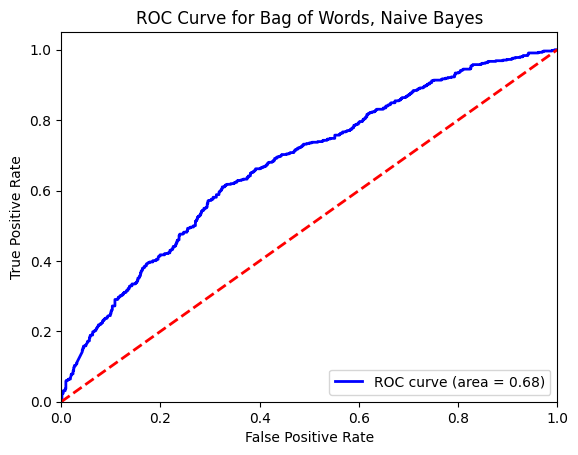

In [108]:
# Классификатор - наивный Байес
name = 'Bag of Words, Naive Bayes'

classifier = MultinomialNB()

param_grid = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 10.0, 100.0],  

    'fit_prior': [True, False]  
}


gs = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=StratifiedKFold(n_folds), scoring='roc_auc', n_jobs=2, return_train_score=True)
gs.fit(X_train_vectors, y_train) 

best_classifier = gs.best_estimator_

best_classifier.fit(X_train_vectors, y_train)
y_pred = best_classifier.predict(X_test_vectors)
y_prob = get_proba(best_classifier)

show_metrics(y_test, y_prob, name)

print("Лучшие параметры классификатора:", gs.best_params_)
print("Best cross-validated score:", gs.best_score_)


# Расчет усредненного training score для лучшего классификатора
best_index = gs.best_index_
train_scores = [gs.cv_results_[f'split{i}_train_score'][best_index] for i in range(gs.cv.n_splits)]
average_train_score = sum(train_scores) / len(train_scores)
print("Средний training score для лучшего классификатора:", average_train_score)
print("Training score для всех фолдов лучшего классификатора:", train_scores)

plot_ROC(y_test, y_prob, name)


Результаты для  Bag of Words, Logistic regression
ROC-AUC для тестовой выборки: 0.6863456464379947
Лучшие параметры классификатора: {'C': 0.1, 'max_iter': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validated score: 0.6807053948396724
Средний training score для лучшего классификатора: 0.8228679906494077
Training score для всех фолдов лучшего классификатора: [0.8230018313406402, 0.8220223799942346, 0.8223289354780408, 0.8223927947466716, 0.8245940116874511]


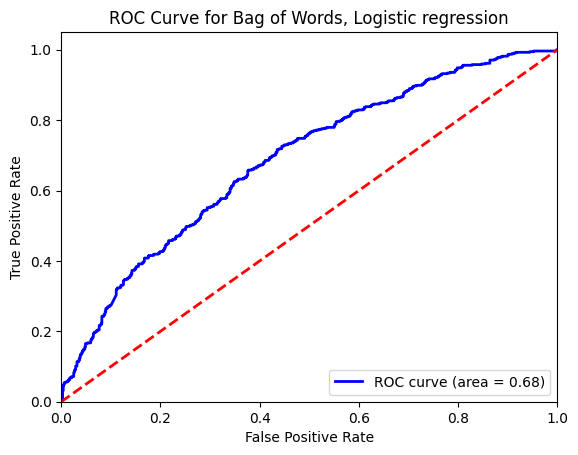

In [109]:
# Классификатор - логистическая регрессия
name = 'Bag of Words, Logistic regression'

classifier = LogisticRegression()

param_grid = {
    'penalty': ['l2'], 
    'C': [0.01, 0.1, 1.0, 10.0, 100.0],   
    'solver': ['liblinear'],  
    'max_iter': [10, 20, 100],
}


gs = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=StratifiedKFold(n_folds), scoring='roc_auc', n_jobs=2, return_train_score=True)
gs.fit(X_train_vectors, y_train) 

best_classifier = gs.best_estimator_

best_classifier.fit(X_train_vectors, y_train)
y_pred = best_classifier.predict(X_test_vectors)
y_prob = get_proba(best_classifier)

show_metrics(y_test, y_prob, name)

print("Лучшие параметры классификатора:", gs.best_params_)
print("Best cross-validated score:", gs.best_score_)


# Расчет усредненного training score для лучшего классификатора
best_index = gs.best_index_
train_scores = [gs.cv_results_[f'split{i}_train_score'][best_index] for i in range(gs.cv.n_splits)]
average_train_score = sum(train_scores) / len(train_scores)
print("Средний training score для лучшего классификатора:", average_train_score)
print("Training score для всех фолдов лучшего классификатора:", train_scores)

plot_ROC(y_test, y_prob, name)



Результаты для  Bag of Words, SVM
ROC-AUC для тестовой выборки: 0.6951463797920223
Лучшие параметры классификатора: {'C': 1, 'kernel': 'rbf'}
Best cross-validated score: 0.6841956175810958
Средний training score для лучшего классификатора: 0.9615605709382373
Training score для всех фолдов лучшего классификатора: [0.9618403586968185, 0.9623184210500946, 0.9602037472136875, 0.961527200433761, 0.9619131272968251]


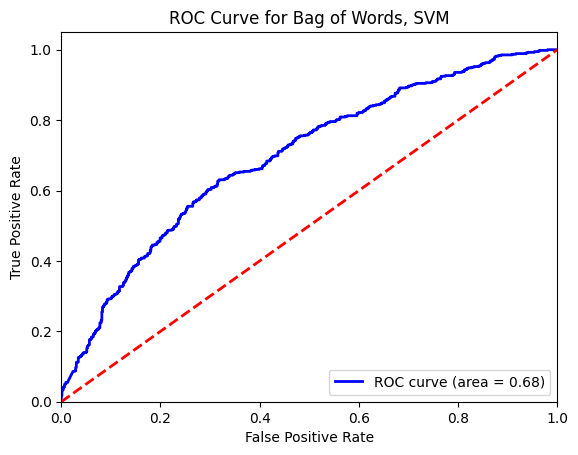

In [112]:
# Классификатор - SVM
name = 'Bag of Words, SVM'

classifier = SVC()
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}


gs = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=StratifiedKFold(n_folds), scoring='roc_auc', n_jobs=2, return_train_score=True)
gs.fit(X_train_vectors, y_train) 

best_classifier = gs.best_estimator_

best_classifier.fit(X_train_vectors, y_train)
y_pred = best_classifier.predict(X_test_vectors)
y_prob = get_proba(best_classifier)

show_metrics(y_test, y_prob, name)

print("Лучшие параметры классификатора:", gs.best_params_)
print("Best cross-validated score:", gs.best_score_)


# Расчет усредненного training score для лучшего классификатора
best_index = gs.best_index_
train_scores = [gs.cv_results_[f'split{i}_train_score'][best_index] for i in range(gs.cv.n_splits)]
average_train_score = sum(train_scores) / len(train_scores)
print("Средний training score для лучшего классификатора:", average_train_score)
print("Training score для всех фолдов лучшего классификатора:", train_scores)

plot_ROC(y_test, y_prob, name)



In [139]:
# Классификатор - XGBoost
name = 'Bag of Words, XGBoost'

dtrain = xgb.DMatrix(X_train_vectors, label=y_train)

params = {
    'objective': 'binary:logistic',
    'max_depth': 8,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eta': 0.1,
    'eval_metric': 'logloss',
    'seed': 42
}

num_boost_round = 100
early_stopping_rounds = 15

# Сделаем кросс-валидацию, используя нативный метод xfb.cv
cv_results = xgb.cv(params, dtrain, num_boost_round=num_boost_round, nfold=n_folds, 
                    metrics={'auc'}, early_stopping_rounds=early_stopping_rounds, 
                    seed=42, verbose_eval=True)

# Метрики для последного раунда бустинга
print("Test AUC Mean:", cv_results['test-auc-mean'].iloc[-1])
print("Train AUC Mean:", cv_results['train-auc-mean'].iloc[-1])





[0]	train-auc:0.63711+0.00268	test-auc:0.59695+0.00635
[1]	train-auc:0.65454+0.00572	test-auc:0.61370+0.00368
[2]	train-auc:0.66878+0.00259	test-auc:0.62542+0.00569
[3]	train-auc:0.67911+0.00433	test-auc:0.63008+0.00502
[4]	train-auc:0.68997+0.00387	test-auc:0.63320+0.00645
[5]	train-auc:0.69250+0.00268	test-auc:0.63444+0.00732
[6]	train-auc:0.69570+0.00352	test-auc:0.63526+0.00960
[7]	train-auc:0.69960+0.00313	test-auc:0.63715+0.00977
[8]	train-auc:0.70286+0.00258	test-auc:0.63817+0.00993
[9]	train-auc:0.70611+0.00303	test-auc:0.63909+0.01175
[10]	train-auc:0.70999+0.00298	test-auc:0.64164+0.01068
[11]	train-auc:0.71359+0.00322	test-auc:0.64449+0.01080
[12]	train-auc:0.71560+0.00362	test-auc:0.64403+0.01201
[13]	train-auc:0.71887+0.00371	test-auc:0.64654+0.01165
[14]	train-auc:0.72188+0.00318	test-auc:0.64750+0.01065
[15]	train-auc:0.72393+0.00330	test-auc:0.64868+0.01178
[16]	train-auc:0.72728+0.00353	test-auc:0.64919+0.01198
[17]	train-auc:0.72973+0.00362	test-auc:0.65087+0.01105
[1

In [140]:
# Определим ROC_AUC на тестовых данных

dtest = xgb.DMatrix(X_test_vectors, label=y_test)
y_test_pred = model.predict(dtest, iteration_range=(0, model.best_iteration + 1))

roc_auc_test = roc_auc_score(y_test, y_test_pred)

print("ROC AUC Score on Testing Data: {:.3f}".format(roc_auc_test))


ROC AUC Score on Testing Data: 0.671


# ВекторизацияTD-IDF с униграмами и биграмами 

In [154]:
# TF-IDF with unigrams and bigrams
vectorizer = TfidfVectorizer(ngram_range=(1, 2))

X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)




In [159]:
print("Training data shape:", X_train_vectors.shape)
print("Testing data shape:", X_test_vectors.shape)

if X_train_vectors.shape[1] != X_test_vectors.shape[1]:
    print("Mismatch in number of features. Training has {}, testing has {}.".format(X_train_vectors.shape[1], X_test_vectors.shape[1]))


Training data shape: (5206, 27561)
Testing data shape: (1302, 27561)


Результаты для  TDF-IF, Naive Bayes
ROC-AUC для тестовой выборки: 0.6640649251125252
Лучшие параметры классификатора: {'alpha': 10.0, 'fit_prior': True}
Best cross-validated score: 0.6837720011256464
Средний training score для лучшего классификатора: 0.8808425189429162
Training score для всех фолдов лучшего классификатора: [0.881794496815348, 0.8804870177136792, 0.8789531899512019, 0.880051810350021, 0.8829260798843304]


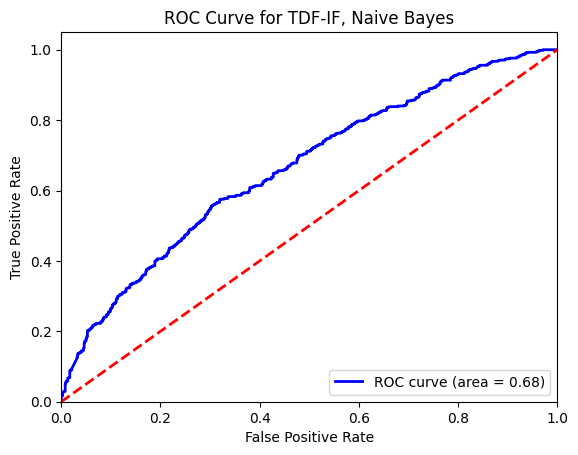

In [155]:
# Классификатор - наивный Байес
name = 'TDF-IF, Naive Bayes'

classifier = MultinomialNB()

param_grid = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 10.0, 100.0],  

    'fit_prior': [True, False]  
}


gs = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=StratifiedKFold(n_folds), scoring='roc_auc', n_jobs=2, return_train_score=True)
gs.fit(X_train_vectors, y_train) 

best_classifier = gs.best_estimator_

best_classifier.fit(X_train_vectors, y_train)
y_pred = best_classifier.predict(X_test_vectors)
y_prob = get_proba(best_classifier)

show_metrics(y_test, y_prob, name)

print("Лучшие параметры классификатора:", gs.best_params_)
print("Best cross-validated score:", gs.best_score_)


# Расчет усредненного training score для лучшего классификатора
best_index = gs.best_index_
train_scores = [gs.cv_results_[f'split{i}_train_score'][best_index] for i in range(gs.cv.n_splits)]
average_train_score = sum(train_scores) / len(train_scores)
print("Средний training score для лучшего классификатора:", average_train_score)
print("Training score для всех фолдов лучшего классификатора:", train_scores)

plot_ROC(y_test, y_prob, name)


Результаты для  TDF-IF, Logistic regression
ROC-AUC для тестовой выборки: 0.6780311481452739
Лучшие параметры классификатора: {'C': 1.0, 'max_iter': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validated score: 0.6854326180254153
Средний training score для лучшего классификатора: 0.9691776798568945
Training score для всех фолдов лучшего классификатора: [0.9691428144293727, 0.9688114924398947, 0.968521959154166, 0.9698355322609795, 0.9695766010000602]


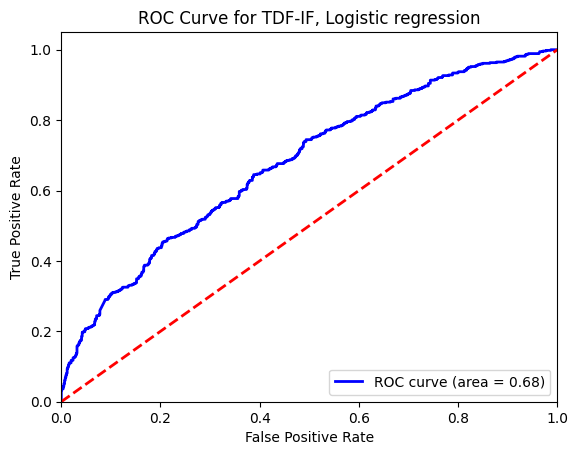

In [145]:
# Классификатор - логистическая регрессия
name = 'TDF-IF, Logistic regression'

classifier = LogisticRegression()

param_grid = {
    'penalty': ['l2'], 
    'C': [0.01, 0.1, 1.0, 10.0, 100.0],   
    'solver': ['liblinear'],  
    'max_iter': [10, 20, 100],
}


gs = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=StratifiedKFold(n_folds), scoring='roc_auc', n_jobs=2, return_train_score=True)
gs.fit(X_train_vectors, y_train) 

best_classifier = gs.best_estimator_

best_classifier.fit(X_train_vectors, y_train)
y_pred = best_classifier.predict(X_test_vectors)
y_prob = get_proba(best_classifier)

show_metrics(y_test, y_prob, name)

print("Лучшие параметры классификатора:", gs.best_params_)
print("Best cross-validated score:", gs.best_score_)


# Расчет усредненного training score для лучшего классификатора
best_index = gs.best_index_
train_scores = [gs.cv_results_[f'split{i}_train_score'][best_index] for i in range(gs.cv.n_splits)]
average_train_score = sum(train_scores) / len(train_scores)
print("Средний training score для лучшего классификатора:", average_train_score)
print("Training score для всех фолдов лучшего классификатора:", train_scores)

plot_ROC(y_test, y_prob, name)



Результаты для  TDF-IF, SVM
ROC-AUC для тестовой выборки: 0.6750652355269284
Лучшие параметры классификатора: {'C': 0.1, 'kernel': 'rbf'}
Best cross-validated score: 0.6873137768743527
Средний training score для лучшего классификатора: 0.9981814671455289
Training score для всех фолдов лучшего классификатора: [0.997815170830686, 0.9979345047969526, 0.9982919452979095, 0.9986931742876076, 0.9981725405144889]


/Users/valentinnovikov/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/valentinnovikov/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/valentinnovikov/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

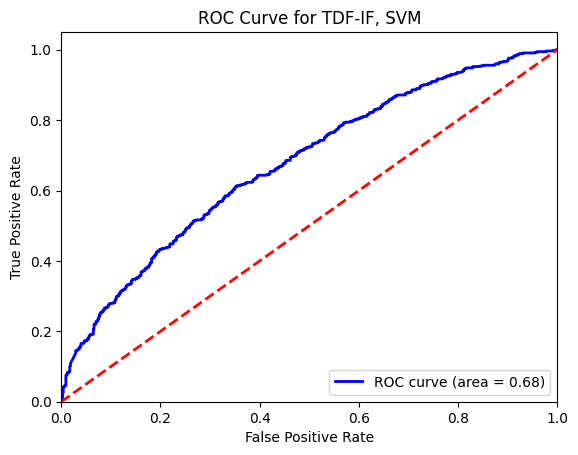

In [146]:
# Классификатор - SVM
name = 'TDF-IF, SVM'

classifier = SVC()
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}


gs = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=StratifiedKFold(n_folds), scoring='roc_auc', n_jobs=2, return_train_score=True)
gs.fit(X_train_vectors, y_train) 

best_classifier = gs.best_estimator_

best_classifier.fit(X_train_vectors, y_train)
y_pred = best_classifier.predict(X_test_vectors)
y_prob = get_proba(best_classifier)

show_metrics(y_test, y_prob, name)

print("Лучшие параметры классификатора:", gs.best_params_)
print("Best cross-validated score:", gs.best_score_)


# Расчет усредненного training score для лучшего классификатора
best_index = gs.best_index_
train_scores = [gs.cv_results_[f'split{i}_train_score'][best_index] for i in range(gs.cv.n_splits)]
average_train_score = sum(train_scores) / len(train_scores)
print("Средний training score для лучшего классификатора:", average_train_score)
print("Training score для всех фолдов лучшего классификатора:", train_scores)

plot_ROC(y_test, y_prob, name)



In [156]:
# Классификатор - XGBoost
name = 'TDF-IF, XGBoost'

dtrain = xgb.DMatrix(X_train_vectors, label=y_train)

params = {
    'objective': 'binary:logistic',
    'max_depth': 8,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eta': 0.1,
    'eval_metric': 'logloss',
    'seed': 42
}

num_boost_round = 100
early_stopping_rounds = 15

# Сделаем кросс-валидацию, используя нативный метод xfb.cv
cv_results = xgb.cv(params, dtrain, num_boost_round=num_boost_round, nfold=n_folds, 
                    metrics={'auc'}, early_stopping_rounds=early_stopping_rounds, 
                    seed=42, verbose_eval=True)

# Метрики для последного раунда бустинга
print("Test AUC Mean:", cv_results['test-auc-mean'].iloc[-1])
print("Train AUC Mean:", cv_results['train-auc-mean'].iloc[-1])







[0]	train-auc:0.61521+0.01310	test-auc:0.55245+0.01139
[1]	train-auc:0.65805+0.00707	test-auc:0.57442+0.01593
[2]	train-auc:0.68964+0.00643	test-auc:0.60449+0.01565
[3]	train-auc:0.70099+0.00337	test-auc:0.61024+0.01792
[4]	train-auc:0.70954+0.00300	test-auc:0.61450+0.01810
[5]	train-auc:0.71615+0.00450	test-auc:0.62096+0.01613
[6]	train-auc:0.71832+0.00394	test-auc:0.62373+0.01465
[7]	train-auc:0.72453+0.00413	test-auc:0.62899+0.01410
[8]	train-auc:0.72922+0.00344	test-auc:0.63449+0.01355
[9]	train-auc:0.73473+0.00191	test-auc:0.63437+0.01301
[10]	train-auc:0.74015+0.00123	test-auc:0.63808+0.01079
[11]	train-auc:0.74413+0.00149	test-auc:0.63814+0.01202
[12]	train-auc:0.74733+0.00232	test-auc:0.63990+0.01023
[13]	train-auc:0.75096+0.00197	test-auc:0.64284+0.01075
[14]	train-auc:0.75432+0.00205	test-auc:0.64252+0.01002
[15]	train-auc:0.75859+0.00317	test-auc:0.64359+0.00913
[16]	train-auc:0.76181+0.00194	test-auc:0.64510+0.00909
[17]	train-auc:0.76495+0.00202	test-auc:0.64535+0.01073
[1